In [13]:
import pandas as pd


df = pd.read_csv('data/combined_data.csv')  
print(df.head())
print(df['label'].value_counts())  # баланс классов

   label                                               text
0      1  ounce feather bowl hummingbird opec moment ala...
1      1  wulvob get your medircations online qnb ikud v...
2      0   computer connection from cnn com wednesday es...
3      1  university degree obtain a prosperous future m...
4      0  thanks for all your answers guys i know i shou...
label
1    43910
0    39538
Name: count, dtype: int64


In [14]:
import re

def preprocess_minimal(text):
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'\S+@\S+', '', text)  # email
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # только буквы и пробелы
    return text.lower().strip()

In [15]:
import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess_lemmatize(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
    return ' '.join(tokens)

In [16]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_stopwords(text):
    tokens = re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akaku\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:

def preprocess_full(text):
    # Шаг 1: очистка от URL, email, цифр, спецсимволов
    text = re.sub(r'http[s]?://.*', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    tokens = re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)

In [18]:

df['minimal'] = df['text'].apply(preprocess_minimal)

df[['text', 'label', 'minimal']].to_csv('preprocessed_minimal.csv', index=False)
print("Минимальная предобработка завершена и сохранена.")

Минимальная предобработка завершена и сохранена.


In [19]:
df['stopwords'] = df['text'].apply(preprocess_stopwords)
# Сохранение результата
df[['text', 'label', 'stopwords']].to_csv('preprocessed_stopwords.csv', index=False)
print("Удаление стоп‑слов завершено и сохранено.")

Удаление стоп‑слов завершено и сохранено.


In [20]:
#df['lemmatize'] = df['text'].apply(preprocess_lemmatize)
#
## Сохранение результата
#df[['text', 'label', 'lemmatize']].to_csv('preprocessed_lemmatize.csv', index=False)
#print("Лемматизация завершена и сохранена.")

In [21]:
df['full'] = df['text'].apply(preprocess_full)
# Сохранение результата
df[['text', 'label', 'full']].to_csv('preprocessed_full.csv', index=False)
print("Комплексная предобработка завершена и сохранена.")

Комплексная предобработка завершена и сохранена.


In [22]:
print("\nПримеры предобработки:")
for col in ['minimal',  'stopwords', 'full']: #'lemmatize',
    print(f"{col}: {df[col].iloc[0][:100]}...")


Примеры предобработки:
minimal: ounce feather bowl hummingbird opec moment alabaster valkyrie dyad bread flack desperate iambic hadr...
stopwords: ounce feather bowl hummingbird opec moment alabaster valkyrie dyad bread flack desperate iambic hadr...
full: ounce feather bowl hummingbird opec moment alabaster valkyrie dyad bread flack desperate iambic hadr...


In [23]:
from gensim.models import Word2Vec
import numpy as np

def train_word2vec(sentences, size=100, window=5, min_count=2):
    model = Word2Vec(
        sentences=[s.split() for s in sentences],
        vector_size=size,
        window=window,
        min_count=min_count,
        sg=1  # Skip-gram
    )
    return model

def get_sentence_vector(sentence, model, vector_size=100):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Параметры Word2Vec
VECTOR_SIZE = 50
WINDOW = 5
MIN_COUNT = 2

# Словарь для хранения результатов
results = {}

for preproc_type in ['minimal',  'stopwords', 'full']: #'lemmatize',
    print(f"\n--- Обработка: {preproc_type} ---")
    
    # Обучаем Word2Vec на текущем варианте
    sentences = df[preproc_type].tolist()
    w2v_model = train_word2vec(sentences, VECTOR_SIZE, WINDOW, MIN_COUNT)
    
    # Векторизуем все тексты
    X_vectors = np.array([
        get_sentence_vector(text, w2v_model, VECTOR_SIZE)
        for text in sentences
    ])
    
    # Разделяем данные
    X_train, X_test, y_train, y_test = train_test_split(
        X_vectors, df['label'], test_size=0.2, random_state=42, stratify=df['label']
    )
    
    # Обучаем классификатор
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    
    # Предсказываем
    y_pred = clf.predict(X_test)
    
    # Сохраняем результаты
    results[preproc_type] = {
        'y_test': y_test,
        'y_pred': y_pred,
        'accuracy': accuracy_score(y_test, y_pred),
        'model': clf
    }
    
    print(f"Accuracy: {results[preproc_type]['accuracy']:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))



--- Обработка: minimal ---
Accuracy: 0.9649
Classification Report:
              precision    recall  f1-score   support

         ham       0.96      0.96      0.96      7908
        spam       0.97      0.97      0.97      8782

    accuracy                           0.96     16690
   macro avg       0.96      0.96      0.96     16690
weighted avg       0.96      0.96      0.96     16690


--- Обработка: stopwords ---
Accuracy: 0.9679
Classification Report:
              precision    recall  f1-score   support

         ham       0.97      0.96      0.97      7908
        spam       0.97      0.97      0.97      8782

    accuracy                           0.97     16690
   macro avg       0.97      0.97      0.97     16690
weighted avg       0.97      0.97      0.97     16690


--- Обработка: full ---
Accuracy: 0.9665
Classification Report:
              precision    recall  f1-score   support

         ham       0.97      0.96      0.96      7908
        spam       0.97      0.97 

In [27]:

print("\n=== Проверка данных для отчёта ===")
for preproc_type, res in results.items():
    y_test = res['y_test']
    y_pred = res['y_pred']
    print(f"\nМетод: {preproc_type}")
    print(f"y_test (уникальные): {np.unique(y_test)}")
    print(f"y_pred (уникальные): {np.unique(y_pred)}")
    print(f"Распределение y_test: {pd.Series(y_test).value_counts().sort_index()}")
    print(f"Распределение y_pred: {pd.Series(y_pred).value_counts().sort_index()}")


=== Проверка данных для отчёта ===

Метод: minimal
y_test (уникальные): [0 1]
y_pred (уникальные): [0 1]
Распределение y_test: label
0    7908
1    8782
Name: count, dtype: int64
Распределение y_pred: 0    7914
1    8776
Name: count, dtype: int64

Метод: stopwords
y_test (уникальные): [0 1]
y_pred (уникальные): [0 1]
Распределение y_test: label
0    7908
1    8782
Name: count, dtype: int64
Распределение y_pred: 0    7868
1    8822
Name: count, dtype: int64

Метод: full
y_test (уникальные): [0 1]
y_pred (уникальные): [0 1]
Распределение y_test: label
0    7908
1    8782
Name: count, dtype: int64
Распределение y_pred: 0    7869
1    8821
Name: count, dtype: int64


In [29]:
print("\n=== Итоговое сравнение ===")
comparison = []
for preproc_type, res in results.items():
    report = classification_report(res['y_test'], res['y_pred'], output_dict=True)
    print(report)
    comparison.append({
        'Метод': preproc_type,
        'Accuracy': res['accuracy'],
        'Precision_spam': report['1']['precision'],
        'Recall_spam': report['1']['recall'],      # Исправлено: было 'recall'
        'F1_spam': report['1']['f1-score']
    })

comparison_df = pd.DataFrame(comparison)
print(comparison_df.round(4))


=== Итоговое сравнение ===
{'0': {'precision': 0.9625979277230224, 'recall': 0.9633282751643905, 'f1-score': 0.9629629629629629, 'support': 7908.0}, '1': {'precision': 0.9669553327256153, 'recall': 0.966294693691642, 'f1-score': 0.9666249003303338, 'support': 8782.0}, 'accuracy': 0.9648891551827442, 'macro avg': {'precision': 0.9647766302243188, 'recall': 0.9648114844280162, 'f1-score': 0.9647939316466483, 'support': 16690.0}, 'weighted avg': {'precision': 0.9648907216554832, 'recall': 0.9648891551827442, 'f1-score': 0.9648898134099523, 'support': 16690.0}}
{'0': {'precision': 0.9684799186578547, 'recall': 0.9635811836115327, 'f1-score': 0.966024340770791, 'support': 7908.0}, '1': {'precision': 0.9673543414191793, 'recall': 0.9717604190389433, 'f1-score': 0.9695523744603499, 'support': 8782.0}, 'accuracy': 0.9678849610545237, 'macro avg': {'precision': 0.967917130038517, 'recall': 0.967670801325238, 'f1-score': 0.9677883576155705, 'support': 16690.0}, 'weighted avg': {'precision': 0.9


Лучший метод по F1 для спама: stopwords


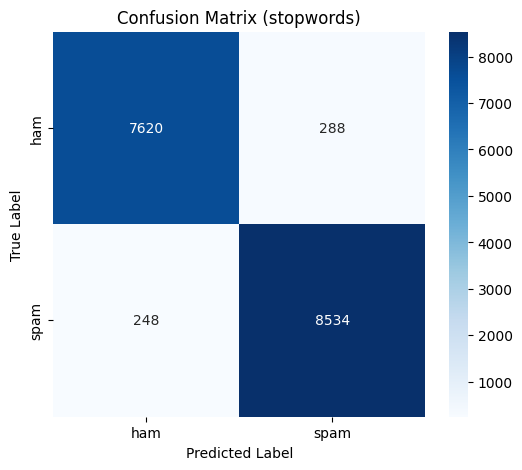

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

best_method = comparison_df.loc[comparison_df['F1_spam'].idxmax(), 'Метод']
print(f"\nЛучший метод по F1 для спама: {best_method}")

plt.figure(figsize=(6, 5))
cm = confusion_matrix(results[best_method]['y_test'], results[best_method]['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
             xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title(f'Confusion Matrix ({best_method})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

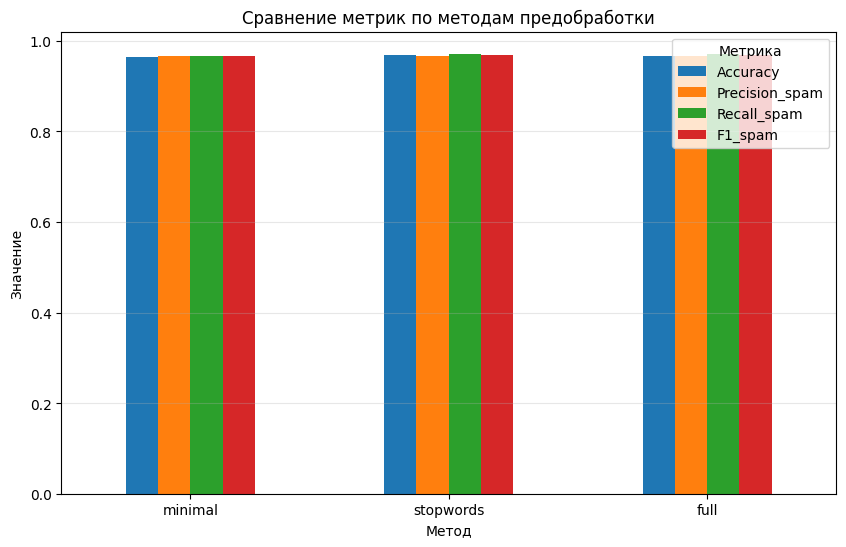

In [31]:
metrics = ['Accuracy', 'Precision_spam', 'Recall_spam', 'F1_spam']
comparison_df.set_index('Метод')[metrics].plot(kind='bar', figsize=(10, 6))
plt.title('Сравнение метрик по методам предобработки')
plt.ylabel('Значение')
plt.xticks(rotation=0)
plt.legend(title='Метрика')
plt.grid(axis='y', alpha=0.3)
plt.show()

Вывод: существенной разницы между медотами предобработки не выявлено. Ламматизация не выполнялась, т.к. оооочень медленная.